In [1]:
from seaborn import load_dataset
from sklearn.model_selection import StratifiedKFold
from junifer.storage import HDF5FeatureStorage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nilearn import plotting
#from junifer.data import parcellations
# from julearn import run_cross_validation
# from julearn import PipelineCreator

In [12]:
from julearn import run_cross_validation
from julearn import PipelineCreator
from julearn.utils import configure_logging
from sklearn.model_selection import StratifiedKFold
from julearn.viz import plot_scores
from junifer.storage import HDF5FeatureStorage
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
storage = HDF5FeatureStorage("./test.hdf5")
df_fc = storage.read_df('BOLD_parccortical-TianxS3x3TxMNI6thgeneration')
df_alff = storage.read_df('BOLD_ALFF_parccortical-TianxS3x3TxMNI6thgeneration')
df_participants = pd.read_csv("./participants.tsv", sep="\t")
df_participants.rename(columns={"participant_id": "subject"}, inplace=True)
df_participants.set_index("subject", inplace=True)
parcellation_labels = df_alff.columns.values

In [23]:
df_alff_full = df_alff.merge(df_participants, on="subject")
df_fc_full = df_fc.merge(df_participants, on="subject")

In [28]:
es_control = lambda x: 1 if x =="CONTROL" else 0
df_fc_full["is_control"] = df_fc_full["diagnosis"].apply(es_control)
df_alff_full["is_control"] = df_alff_full["diagnosis"].apply(es_control)

In [72]:
df_fc_dev, df_fc_test = train_test_split(df_fc_full, test_size=0.2, stratify=df_fc_full["is_control"])
df_alff_dev, df_alff_test = df_alff_full.loc[df_fc_dev.index], df_alff_full.loc[df_fc_test.index]

x_fc_cols, x_alff_cols, target = list(df_fc.columns), list(df_alff.columns),  "is_control" 

<Figure size 1000x800 with 0 Axes>

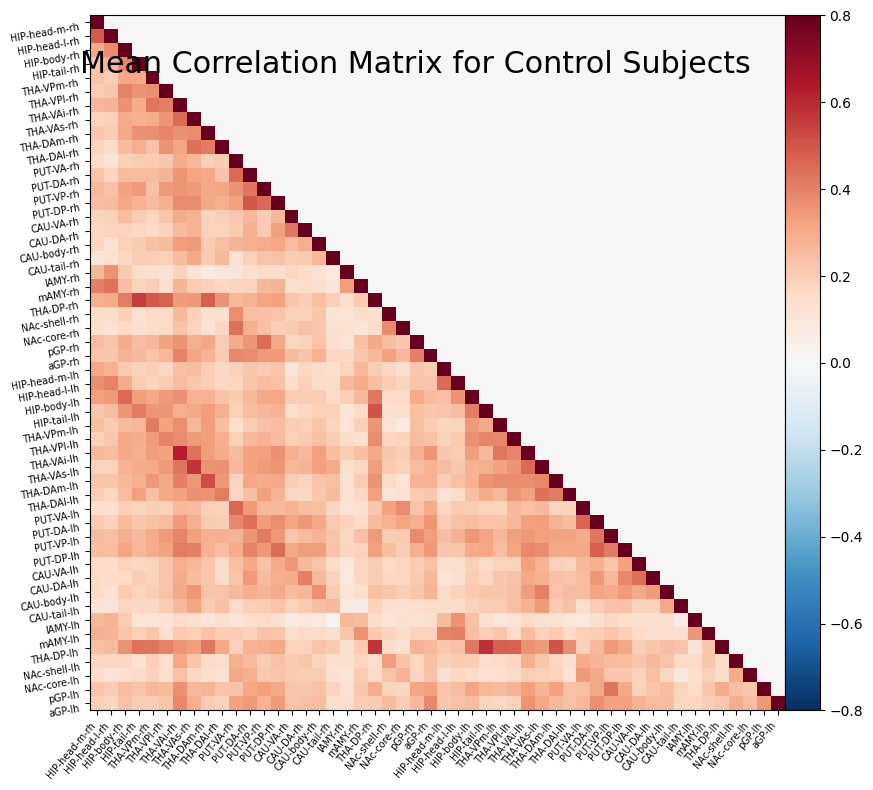

<Figure size 1000x800 with 0 Axes>

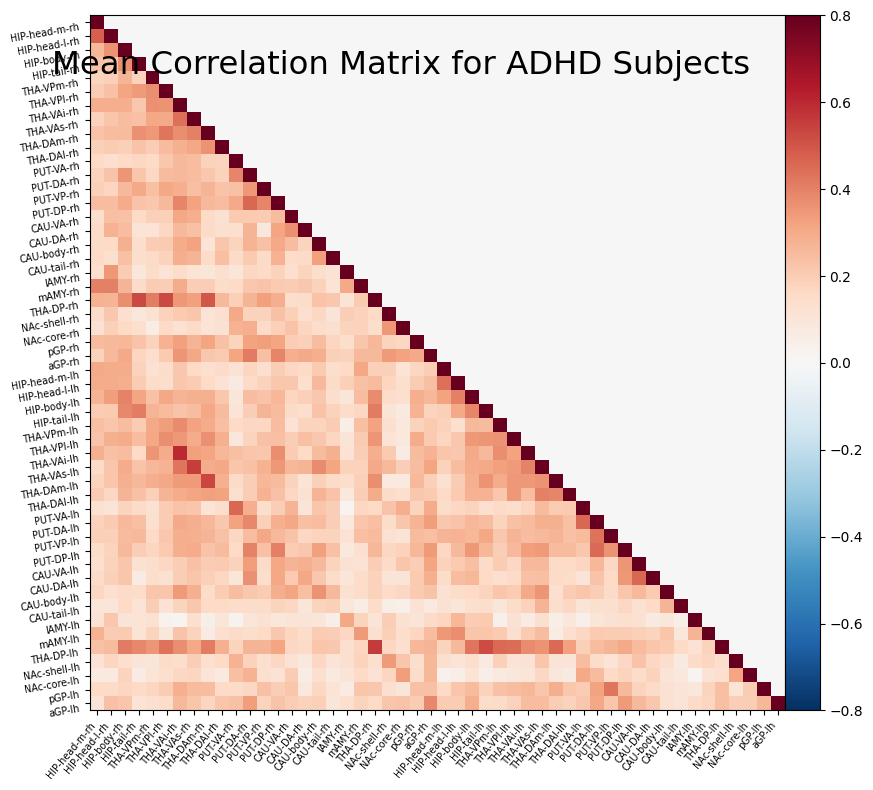

<Figure size 1000x800 with 0 Axes>

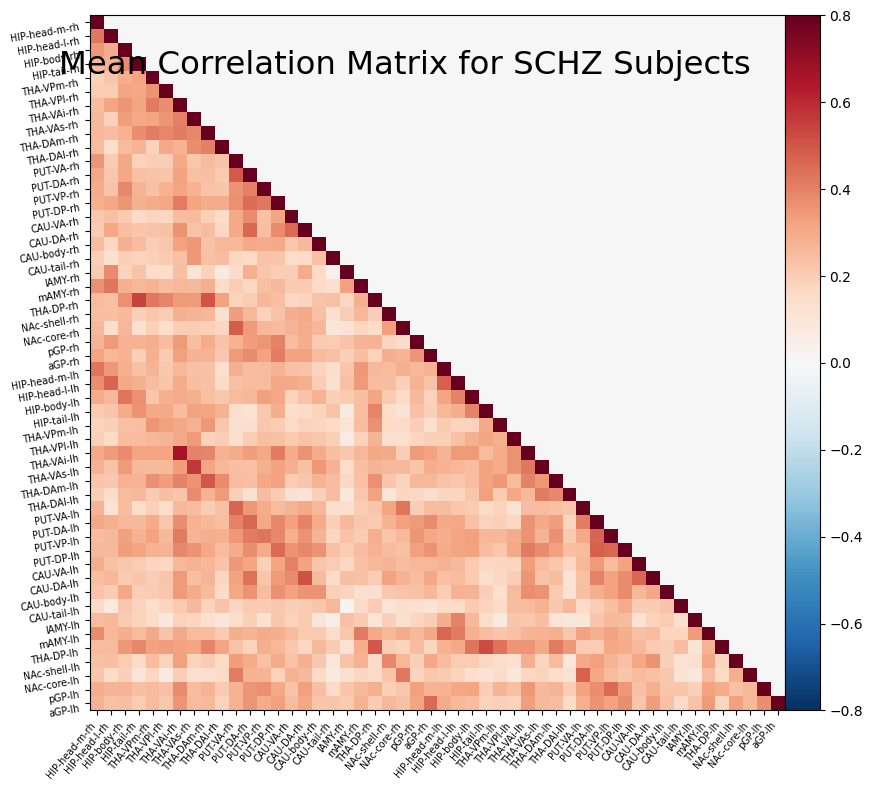

In [94]:
def plot_correlation_matrix(lower_tri_array, parcellation, title="Correlation Matrix"):
    n = int((np.sqrt(1 + 8 * len(lower_tri_array)) - 1) / 2)
    
    corr_matrix = np.zeros((n, n))
    
    tri_indices = np.tril_indices(n)
    corr_matrix[tri_indices] = lower_tri_array

    plt.figure(figsize=(10, 8))
    plotting.plot_matrix(corr_matrix, figure=(10, 8), labels=parcellation, colorbar=True, vmax=0.8, vmin=-0.8, title=title)
    plt.show()

# Get the mean value of the correlation matrix for all subjects with diagnosis AD
lower_mean_control = df_fc_full[df_fc_full['diagnosis'] == 'CONTROL'][df_fc.columns].mean().values
lower_mean_adhd = df_fc_full[df_fc_full['diagnosis'] == 'ADHD'][df_fc.columns].mean().values
lower_mean_schz = df_fc_full[df_fc_full['diagnosis'] == 'SCHZ'][df_fc.columns].mean().values

plot_correlation_matrix(lower_mean_control, parcellation=parcellation_labels, title="Mean Correlation Matrix for Control Subjects")
plot_correlation_matrix(lower_mean_adhd, parcellation=parcellation_labels, title="Mean Correlation Matrix for ADHD Subjects")
plot_correlation_matrix(lower_mean_schz, parcellation=parcellation_labels, title="Mean Correlation Matrix for SCHZ Subjects")


In [49]:
from sklearn.decomposition import PCA

In [61]:
pca = PCA(n_components = 150)
X_fc_dev = df_fc 
pca.fit(X_fc_dev)

PCA(n_components=150)

In [62]:
sum(pca.explained_variance_ratio_)

0.9225417748093605

In [64]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)

In [89]:
X_fc_dev = df_fc_dev
pca = PCA(n_components=100)
X_fc_dev_pca = pca.fit_transform(X_fc_dev[x_fc_cols])

In [119]:
df_fc_dev_pca = pd.DataFrame(X_fc_dev_pca, columns = list([str(x) for x in range(X_fc_dev_pca.shape[1])]), index=df_fc_dev.index)
df_fc_dev_pca_cols = list(df_fc_dev_pca.columns)
df_fc_dev_pca[target] = df_fc_dev[target].values

In [132]:
creator1 = PipelineCreator(problem_type="classification")
creator1.add("zscore")
creator1.add("svm", kernel="rbf", C=np.logspace(-3,3,10), gamma=np.logspace(-3,3,10))

In [133]:
scores, model, inspector = run_cross_validation(
    X= x_alff_cols,
    y=target,
    data = df_alff_dev,
    model=creator1,
    cv=cv,
    return_train_score=True,
    return_estimator="all",
    search_params={"cv":StratifiedKFold(n_splits=3)},
    return_inspector=True
)

The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA-VPm-rh', 'THA-VPl-rh', 'THA-VAi-rh', 'THA-VAs-rh', 'THA-DAm-rh', 'THA-DAl-rh', 'PUT-VA-rh', 'PUT-DA-rh', 'PUT-VP-rh', 'PUT-DP-rh', 'CAU-VA-rh', 'CAU-DA-rh', 'CAU-body-rh', 'CAU-tail-rh', 'lAMY-rh', 'mAMY-rh', 'THA-DP-rh', 'NAc-shell-rh', 'NAc-core-rh', 'pGP-rh', 'aGP-rh', 'HIP-head-m-lh', 'HIP-head-l-lh', 'HIP-body-lh', 'HIP-tail-lh', 'THA-VPm-lh', 'THA-VPl-lh', 'THA-VAi-lh', 'THA-VAs-lh', 'THA-DAm-lh', 'THA-DAl-lh', 'PUT-VA-lh', 'PUT-DA-lh', 'PUT-VP-lh', 'PUT-DP-lh', 'CAU-VA-lh', 'CAU-DA-lh', 'CAU-body-lh', 'CAU-tail-lh', 'lAMY-lh', 'mAMY-lh', 'THA-DP-lh', 'NAc-shell-lh', 'NAc-core-lh', 'pGP-lh', 'aGP-lh']. They will be treated as continuous.
/home/nyanovsky/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['HIP-head-m-rh', 'HIP-head-l-rh', 'HIP-body-rh', 'HIP-tail-rh', 'THA

In [134]:
scores

,fit_time,score_time,estimator,test_score,train_score,n_train,n_test,repeat,fold,cv_mdsum
0,7.755166,0.009452,"GridSearchCV(cv=StratifiedKFold(n_splits=3, ra...",0.418605,0.853801,171,43,0,0,4bbff3df81cf8854822a1b557f37a710
1,7.088988,0.012069,"GridSearchCV(cv=StratifiedKFold(n_splits=3, ra...",0.581395,0.596491,171,43,0,1,4bbff3df81cf8854822a1b557f37a710
2,6.923196,0.004589,"GridSearchCV(cv=StratifiedKFold(n_splits=3, ra...",0.604651,0.637427,171,43,0,2,4bbff3df81cf8854822a1b557f37a710
3,7.881019,0.006076,"GridSearchCV(cv=StratifiedKFold(n_splits=3, ra...",0.558140,0.637427,171,43,0,3,4bbff3df81cf8854822a1b557f37a710
4,6.917044,0.011808,"GridSearchCV(cv=StratifiedKFold(n_splits=3, ra...",0.571429,0.662791,172,42,0,4,4bbff3df81cf8854822a1b557f37a710


## Modelo